# Linear Regression implementation

A simple implementation of linear regression for predicting California house prices.

## Problem description

**Goal**: Predict median house values in California 

## Setup

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

set_config(transform_output='pandas')

## Exploratory Analysis

In [69]:
raw = pd.read_csv("data/houses.csv")
raw

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND,78100
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND,77100
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND,92300
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND,84700


In [70]:
# get types and amount of nulls
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


<Axes: xlabel='median_income', ylabel='median_house_value'>

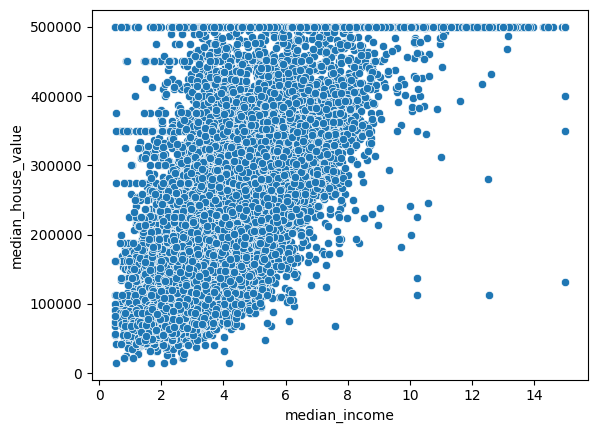

In [71]:
# just get a feeling for plotting one variable

sns.scatterplot(x=raw['median_income'], y=raw['median_house_value'])

## Pre-Processing

### Handle missing values and categorical data

In [ ]:
# use SimpleImputer to fill-in missing values. It supports different strategies, such as: mean, median, most_frequent or constant
imputer_bedrooms = SimpleImputer(strategy='median')

# use OneHotEncoder to transform text values into numerical values
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fill missing values and convert categorical features
transformer = ColumnTransformer(
    transformers=[
        ('impute_bedrooms', imputer_bedrooms, ['total_bedrooms']),   # apply to specific columns
        ('onehot', onehot, ['ocean_proximity'])
    ],
    remainder='passthrough', # all other columns remain untouched
    verbose_feature_names_out=False # keep original column names and not add 'remainder' prefix
)


# perform scaling
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['longitude','latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])
    ],
    remainder='passthrough', # all other columns remain untouched
    verbose_feature_names_out=False # keep original column names and not add 'remainder' prefix
)

# run a pipeline with all transformers
pipeline = Pipeline([
    ('transform', transformer),
    ('scaler', scaler)
])

pipeline.set_output(transform="pandas")

transformed = pipeline.fit_transform(raw)



<Axes: >

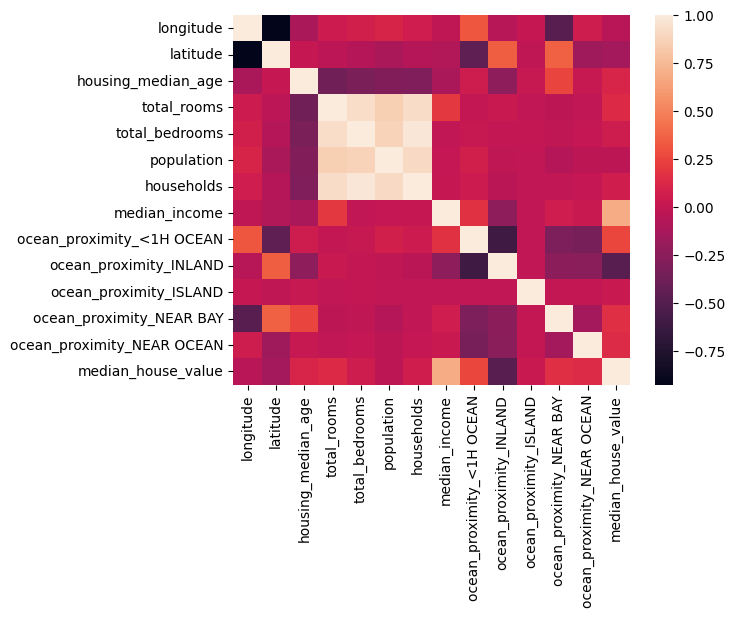

In [84]:
sns.heatmap(transformed.corr())

## Prepare test and train data

In [85]:
# define input, by dropping the result column
X = transformed.drop('median_house_value', axis=1)

# define the result column
y = transformed.median_house_value

# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model

In [86]:
#train the model

model = LinearRegression()  
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Test and Plot Results

In [87]:
# get predictions for test set
predictions = model.predict(X_test)

# Score (R²)
score = r2_score(y_test, predictions)
print(f"R² score: {score:.4f}")

R² score: 0.6254


### Actual vs Predicted

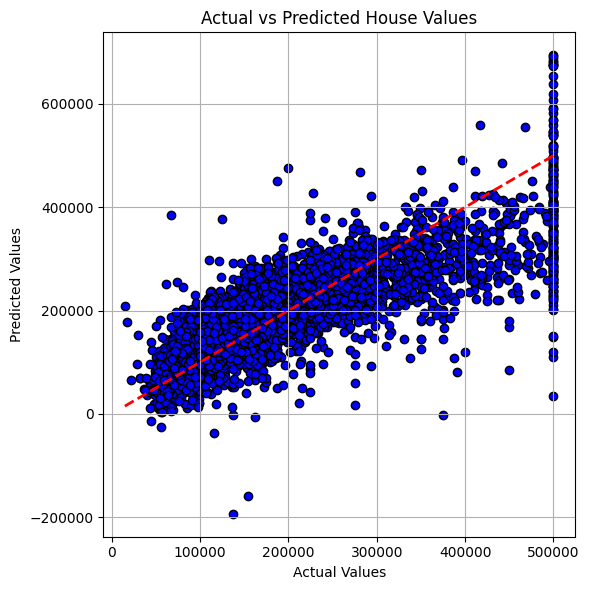

In [88]:
# Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, color='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted House Values")
plt.grid(True)
plt.tight_layout()
plt.show()

### Residuals
(difference between actual and predicted values, mapped by the predicted prices)

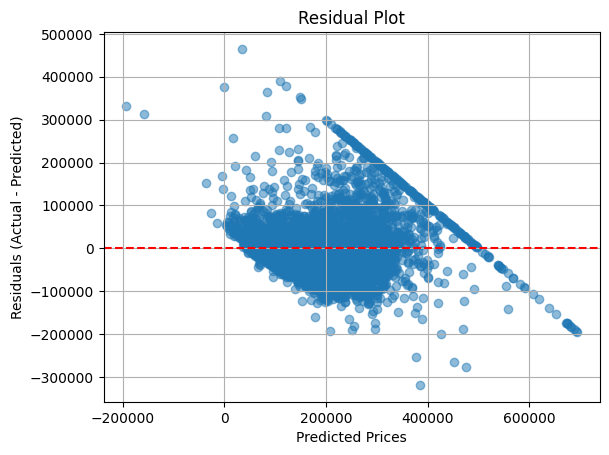

In [89]:
residuals = y_test - predictions

plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

This graph is showing a funnel shape, which means the model has more variance for some values than others. The higher values seems more precise than the lower values. There's also quite a few outliers

### Feature importance
(shows how much each feature contributes to the prediction)

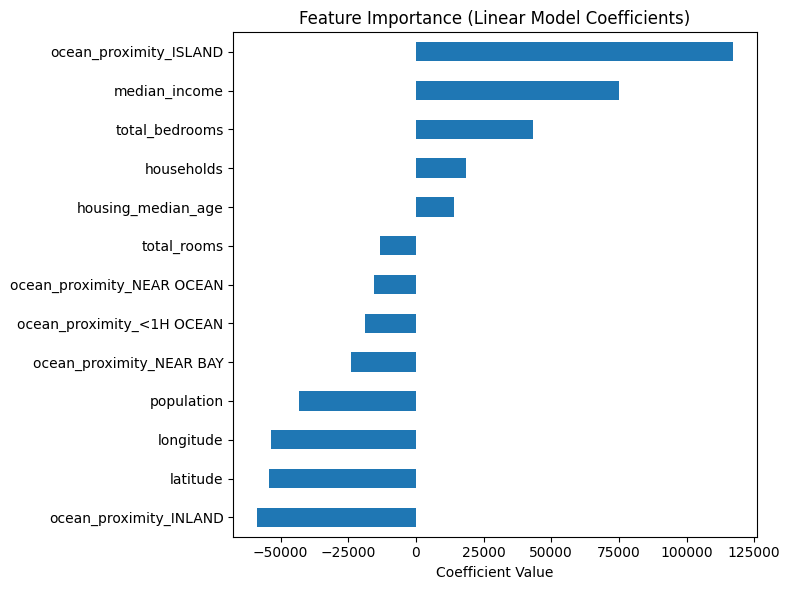

In [90]:

coefs = pd.Series(model.coef_, index=X_test.columns)
coefs.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance (Linear Model Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()